In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('clean_housing.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

# Build a Baseline Model
In order to fit a baseline model for use in comparisons with the more complete model I will conduct these steps:
1. Handle Muliticolinearity
2. Standardize Variables
3. Fit and Validate the Baseline Model

## 1. Handle Multicolinearity 

In [3]:
high_corr = ((abs(data.corr())> .8).sum()>1)
high_corr

price              False
bedrooms           False
bathrooms          False
sqft_living         True
floors             False
view               False
grade              False
sqft_above          True
sqft_basement      False
lat                False
long               False
sqft_living15      False
WaterFront         False
month_sold         False
age                 True
yrs_reno            True
Renovated          False
dist_to_Seattle    False
Bellevue           False
Federal Way        False
Kent               False
Renton             False
Seattle            False
rel_size           False
dtype: bool

In [4]:
data[['sqft_living', 'sqft_above', 'age', 'yrs_reno']].corr()

,sqft_living,sqft_above,age,yrs_reno
sqft_living,1.000000,0.839924,-0.366368,-0.376163
sqft_above,0.839924,1.000000,-0.483546,-0.482755
age,-0.366368,-0.483546,1.000000,0.938759
yrs_reno,-0.376163,-0.482755,0.938759,1.000000


To avoid multicolinearity issues I will drop sqft_above, because the information already exists in a combination of sqft_living and sqft_basement. I will also drop yrs_reno, because the data on whether the house has been renovated or not already exists in the renovated column. 

In [5]:
data.drop(['sqft_above', 'yrs_reno'], axis = 1, 
          inplace = True)

## 2. Standardize Variables 
To standardize the data I'll be using scikit learn's Robust Scalar function because of the existence of significant outliers in the independent variable, price.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16262 entries, 0 to 16261
Data columns (total 22 columns):
price              16262 non-null float64
bedrooms           16262 non-null int64
bathrooms          16262 non-null float64
sqft_living        16262 non-null int64
floors             16262 non-null float64
view               16262 non-null float64
grade              16262 non-null int64
sqft_basement      16262 non-null int64
lat                16262 non-null float64
long               16262 non-null float64
sqft_living15      16262 non-null int64
WaterFront         16262 non-null int64
month_sold         16262 non-null int64
age                16262 non-null int64
Renovated          16262 non-null int64
dist_to_Seattle    16262 non-null float64
Bellevue           16262 non-null int64
Federal Way        16262 non-null int64
Kent               16262 non-null int64
Renton             16262 non-null int64
Seattle            16262 non-null int64
rel_size           16262 non-null flo

In [7]:
#Separate data into categorical and continuous groups. 
cat_data = data[['WaterFront', 'Bellevue', 'Federal Way',
                 'Kent', 'Renton', 'Seattle', 'Renovated']]

con_data = data.drop(['WaterFront', 'Bellevue', 
                      'Federal Way', 'Kent', 'Renton', 
                      'Seattle', 'Renovated'], 
                     axis=1)
con_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16262 entries, 0 to 16261
Data columns (total 15 columns):
price              16262 non-null float64
bedrooms           16262 non-null int64
bathrooms          16262 non-null float64
sqft_living        16262 non-null int64
floors             16262 non-null float64
view               16262 non-null float64
grade              16262 non-null int64
sqft_basement      16262 non-null int64
lat                16262 non-null float64
long               16262 non-null float64
sqft_living15      16262 non-null int64
month_sold         16262 non-null int64
age                16262 non-null int64
dist_to_Seattle    16262 non-null float64
rel_size           16262 non-null float64
dtypes: float64(8), int64(7)
memory usage: 1.9 MB


In [8]:
def scale(col):
    return(con_data[col]-
           con_data[col].mean())/con_data[col].std()

In [9]:
scaled_data = pd.DataFrame([])
for col in con_data.columns:
    scaled_data[col] = scale(col)

In [10]:
#Join continuous and categorical data. 
model_data = scaled_data.join(cat_data, how='outer')
model_data.describe()

,price,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_basement,lat,long,...,age,dist_to_Seattle,rel_size,WaterFront,Bellevue,Federal Way,Kent,Renton,Seattle,Renovated
count,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,1.626200e+04,...,1.626200e+04,1.626200e+04,1.626200e+04,16262.000000,16262.000000,16262.000000,16262.000000,16262.000000,16262.000000,16262.000000
mean,1.396415e-16,-1.339518e-15,1.764874e-15,2.311656e-16,5.501257e-14,-2.082494e-15,1.313944e-15,-4.521070e-15,-2.034863e-12,3.888316e-12,...,-2.037930e-15,-4.419537e-15,-1.550624e-14,0.000615,0.253351,0.074284,0.126491,0.159697,0.386176,0.027364
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,0.024791,0.434944,0.262240,0.332412,0.366336,0.486887,0.163148
min,-2.000057e+00,-2.761373e+00,-2.207734e+00,-2.194753e+00,-8.677580e-01,-2.329389e-01,-4.761209e+00,-6.559474e-01,-2.639059e+00,-1.915580e+00,...,-1.497173e+00,-1.631764e+00,-2.870654e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.874089e-01,-3.046371e-01,-7.224393e-01,-7.500213e-01,-8.677580e-01,-2.329389e-01,-4.435901e-01,-6.559474e-01,-6.177944e-01,-8.332727e-01,...,-9.359216e-01,-8.256997e-01,-5.527940e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.676110e-01,-3.046371e-01,2.020793e-02,-1.393616e-01,-8.677580e-01,-2.329389e-01,-4.435901e-01,-6.559474e-01,6.180182e-02,-3.080356e-01,...,-1.150707e-02,-1.701657e-01,-6.234055e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.374526e-01,9.237310e-01,7.628552e-01,6.202395e-01,9.616944e-01,-2.329389e-01,6.358147e-01,6.295063e-01,8.730094e-01,6.151085e-01,...,6.818038e-01,6.634144e-01,3.991267e-01,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.820085e+00,2.152099e+00,2.990797e+00,4.611869e+00,3.705873e+00,7.290503e+00,3.874029e+00,4.298405e+00,1.575423e+00,3.591452e+00,...,2.332544e+00,3.449029e+00,4.531018e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Build a Baseline Model

In [11]:
X = model_data.drop('price', axis=1)
y = model_data['price']

(X_train,X_test,
 y_train,y_test)=train_test_split(X,y,test_size=.2,
                                  random_state=37)

In [12]:
(X_train,X_test,
 y_train,y_test)=train_test_split(X,y,test_size=.2,
                                  random_state=37)

In [13]:
linreg = LinearRegression()
model1 = linreg.fit(X_train,y_train)

In [14]:
def report(model, ind_train, ind_test):
    """
    Print relevant statistics for a model.
    
    Parameters:
    model: Fitted LinearRegression object
    ind_train: independent variables for training set
    ind_test: independent variables for test set
    """
    pred_y_train = model.predict(ind_train)
    pred_y_test = model.predict(ind_test)
    
    #Print top and bottome variables by size of coefficient.
    coefs = []
    high_coefs = []
    low_coefs = []
    for i in range(0, len(model.coef_)):
        coefs.append((model.coef_[i],ind_train.columns[i]))
    for coef in coefs:
        if ((coef[0] 
            < np.quantile(model.coef_,.05))
            or (coef[0] 
            > np.quantile(model.coef_,.95))):
            high_coefs.append(coef)
    for coef in coefs:
        if ((coef[0] 
            < .05)
            and (coef[0] 
            > -.05)):
            low_coefs.append(coef)
    print('************\nHigh Impact Variables:\n')
    for variable in high_coefs:
        print('Variable: {}\nCoefficient: {}\n'
              .format(variable[1],variable[0]))
    print('************')
    print('************\nLow Impact Variables:\n')
    for variable in low_coefs:
        print('Variable: {}\nCoefficient: {}\n'
              .format(variable[1],variable[0]))
    print('************')

    #Print MSE for the train an test set.
    train_mse = mean_squared_error(y_train, pred_y_train)
    test_mse = mean_squared_error(y_test, pred_y_test)
    print('\nTrain MSE: {}\nTest MSE: {}\nDifference:{}\n'
          .format((train_mse),(test_mse),
                  (train_mse-test_mse)))
    
    #Print R^2 against the test data. 
    print('Train R^2: {}'
          .format((r2_score(y_train,pred_y_train))))
    print('Test R^2: {}\n'
          .format((r2_score(y_test,pred_y_test))))
    

    plotdf = pd.DataFrame([])
    plotdf['test_resids'] = pred_y_test-y_test
    plotdf['y_test'] = y_test
    sns.jointplot(x = 'y_test', y = 'test_resids',
                  data=plotdf, kind='kde')
    plt.show();
    
    plt.scatter(pred_y_test, y_test)
    plt.plot(y_test, y_test, color='black', 
             label='Actual Price')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.legend();

************
High Impact Variables:

Variable: dist_to_Seattle
Coefficient: -0.5110801493065874

Variable: WaterFront
Coefficient: 1.1028082816596785

************
************
Low Impact Variables:

Variable: bedrooms
Coefficient: -0.023909957497513845

Variable: floors
Coefficient: -0.009117290416810107

Variable: month_sold
Coefficient: -0.03691184312517753

************

Train MSE: 0.24765281097909217
Test MSE: 0.24358027868468995
Difference:0.004072532294402215

Train R^2: 0.7502584088529494
Test R^2: 0.7642208342687515



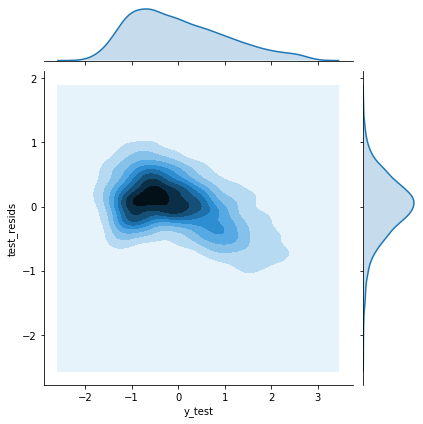

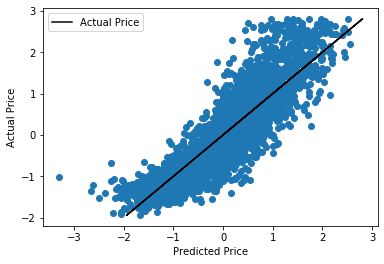

In [15]:
report(model1, X_train, X_test)

Based on the MSE and R-squared, the model seems fairly accurate.

The variables, floors, bedrooms, and month_sold seem to lack predictive influence. Information from the scatterplots during data exploration suggest that this is the result of the relationship being better modeled by polynomial regression.

Finally, based on the KDE plot of residuals, it is clear that the model could be more generalizable, especially for high value homes. Interaction and polynomial features will likely improve predictive quality of the model. 

# Train the Model
In order to train the model and verify it's validity I will conduct the following steps:

1. Find and include interaction features.
2. Find and include polynomial features.
3. Satisfy Assumptions.
4. Validate Model

## Find and Include Interaction Features

In [24]:
def plot_interaction(col1, col2):
    """
    Plot the regression lines of variables grouped by
    high and low values. Non-parellel lines show 
    interaction of variables.
    
    Parameters:
    col1: pandas Series. Variable to group by.
    col2: pandas Series. Variable to plot by
    """
    sample = X_train.join(y_train, how='outer')
    
    hisample = (sample.loc[sample[col1]
                           >sample[col1].quantile(.5)])
    losample = (sample.loc[sample[col1]
                           <sample[col1].quantile(.5)])
    
    fig, axes = plt.subplots(figsize=(6,3))
    sns.regplot(x=col2, y='price', data=hisample, 
                scatter=False, truncate=True,
                label='High Values of {}'.format(col1))
    sns.regplot(x=col2, y='price', data=losample, 
                scatter=False, 
                label='Low Values of {}'.format(col1))
    plt.title('Interaction of {} and {}'.format(col1, col2))
    plt.legend()
    plt.show();
    print('*********************\n')

In [19]:
def find_interactions(n, model, ind_train):
    """
    Returns n most predictive interactions based on low MSE.
    
    Parameters:
    n: int. the number of interactions selected.
    model: LinearRegression() object being tested. 
    ind_train: the independent variables in the training set.
    """
    combos = list(combinations(ind_train.columns, 2))
    print('Testing {} combinations.\n'.format(len(combos)))
    inters = [(0,0,0)]*n
    temp_X = ind_train.loc[:]
    for combo in combos:
        temp_X['interaction']=(ind_train.loc[:, combo[0]]
                               *ind_train.loc[:, combo[1]])
        linreg = LinearRegression()
        model = linreg.fit(temp_X, y_train)
        y_pred = model.predict(temp_X)
        score = round(r2_score(y_train, y_pred),3)
        if score > inters[-1][0]:
            inters.append((score, combo[0], combo[1]))
            inters = sorted(inters, reverse=True)[:n]
    for inter in inters:
        print('R^2 including interaction of {} and {}: {}'
              .format(inter[1], inter[2], inter[0]))
        plot_interaction(inter[1], inter[2])
    fin_inters = [i[1:] for i in inters]
    return fin_inters

Testing 210 combinations.

R^2 including interaction of lat and dist_to_Seattle: 0.771


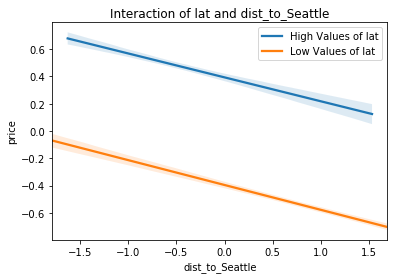

*********************

R^2 including interaction of lat and Seattle: 0.763


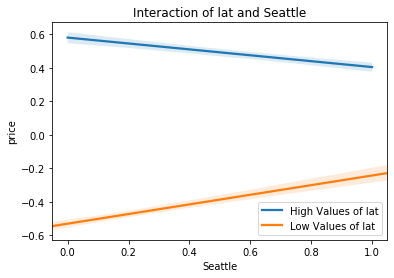

*********************

R^2 including interaction of grade and dist_to_Seattle: 0.762


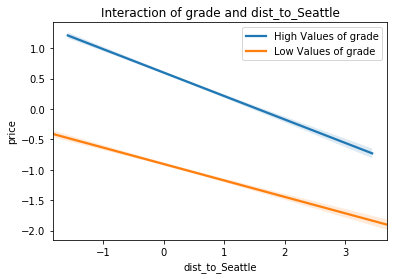

*********************

R^2 including interaction of sqft_living15 and dist_to_Seattle: 0.761


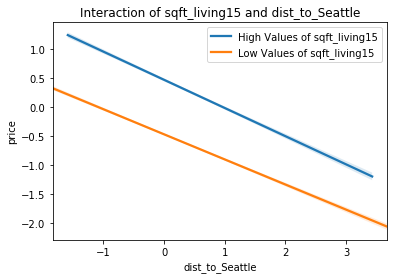

*********************

R^2 including interaction of sqft_living and dist_to_Seattle: 0.761


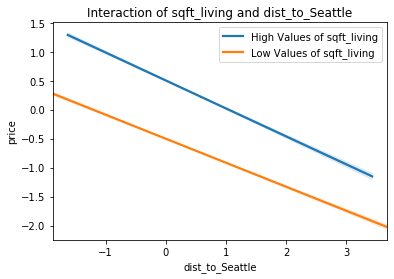

*********************

R^2 including interaction of long and Seattle: 0.761


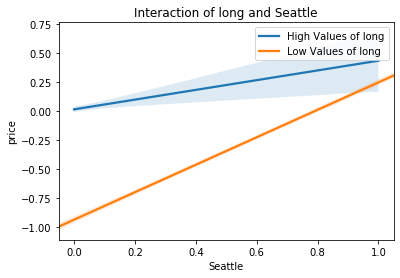

*********************

R^2 including interaction of lat and long: 0.758


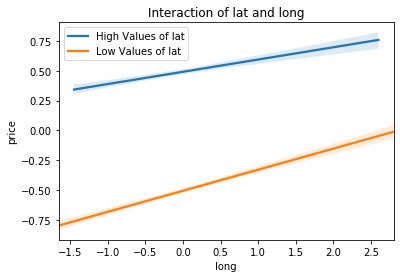

*********************

R^2 including interaction of sqft_living and lat: 0.756


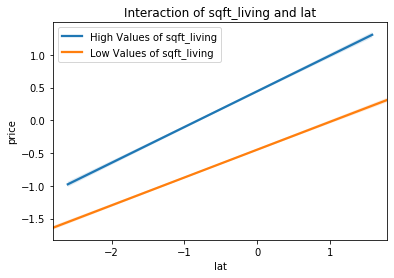

*********************

R^2 including interaction of sqft_living and Kent: 0.756


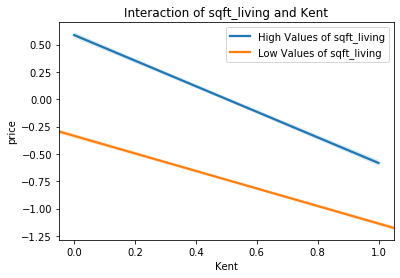

*********************

R^2 including interaction of lat and Bellevue: 0.756


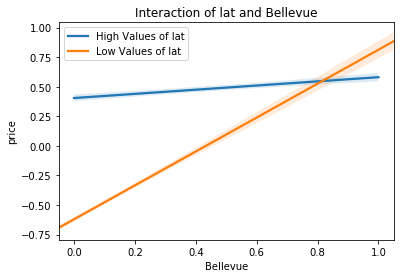

*********************

R^2 including interaction of grade and lat: 0.756


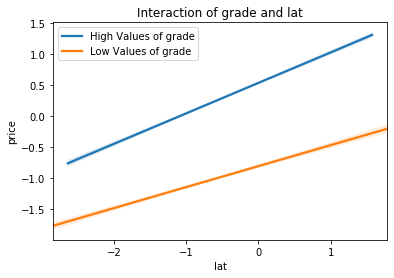

*********************

R^2 including interaction of grade and Kent: 0.756


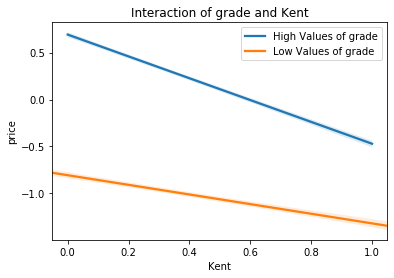

*********************

R^2 including interaction of sqft_living and Seattle: 0.755


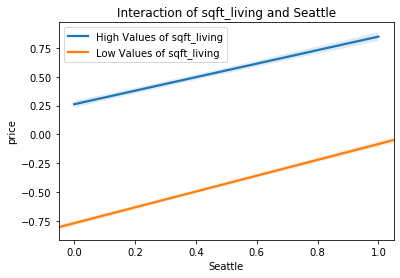

*********************

R^2 including interaction of long and dist_to_Seattle: 0.755


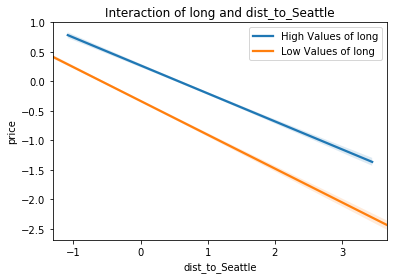

*********************

R^2 including interaction of lat and Kent: 0.755


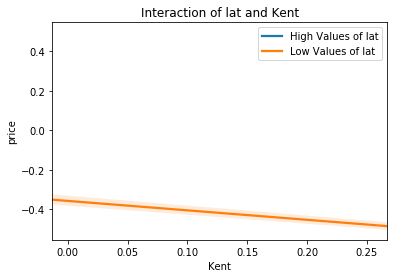

*********************



In [25]:
interactions = find_interactions(15, model1, X_train)

These interactions illustrate an interesting phenomenon. Despite the genral trends, each city seems to have different reactions to the values of the other variables. This is most clear in the chart evaluating the impact of latitude on Bellevue: whereas in most cases the price of a home increases the farther North it is, in Bellevue the trend is reversed.

To get a clearer picture of this phenomenon I will remove variables that explain similar things to see what interactions are observable. Of the variables that appeared in the initial output I'll be removing 'sqft_living15' and 'grade' which are substantially redundant to 'sqft_living' for these purposes, and 'dist_to_Seattle' which is mostly redundant to 'Seattle'

*This removal will only be temporary.

In [ ]:
def add_interactions(interactions, ind_train, ind_test):
    """
    Use forward selection based on lowest MSE to select
    and add most predictive interactions to a new model.
    
    Parameters:
    interactions: list of tuples outputed by find_interaction
    function.
    ind_train: independent variables training data.
    ind_test: independent variables test data.
    
    Returns:
    (new_model, new_x_with_interactions)
    """
    additions = interactions
    X_temp_tr = ind_train.loc[:]
    X_best_tr = ind_train.loc[:]
    X_best_t = ind_test.loc[:]
    scores = []
    baseline = 0
    while additions:
        for inter in additions:
            X_temp_tr[inter[0]
                      +' * '
                      +inter[1]]=(X_temp_tr.loc[:, inter[0]]
                                  *X_temp_tr.loc[:, inter[1]])
            linreg = LinearRegression()
            model = linreg.fit(X_temp_tr, y_train)
            y_pred = model.predict(X_temp_tr)
            score = round(r2_score(y_train, y_pred),5)
            scores.append((score, inter[0], inter[1]))
            best = sorted(scores, reverse=True)[0]
            x_temp_tr = X_best_tr.loc[:]
        print(score)
        scores = []
        if best[0] >= baseline:
            additions.remove(best[1:])
            baseline = best[0]
            X_best_tr[best[1]
                      +' * '
                      +best[2]]=(X_temp_tr.loc[:, best[1]]
                                 * X_temp_tr
                                 .loc[:, best[2]])
            X_best_t[best[1]
                     +' * '
                     +best[2]]=(X_best_t.loc[:, best[1]]
                                *X_best_t.loc[:, best[2]])
            linreg = LinearRegression()
            model = linreg.fit(X_best_tr, y_train)
            y_pred = model.predict(X_best_tr)
            t_pred = model.predict(X_best_t)
            print('Interaction Added: {} * {}'
                  .format(best[1], best[2]))
            print('Current R^2: {}'
                  .format(best[0]))
            print('Current Test MSE: {}'
                  .format(round(mean_squared_error
                                (y_test, t_pred),5)))
            print('Current MSE Difference: {}\n'
                  .format(round(best[0]
                          -round(mean_squared_error
                                 (y_test, t_pred),5),5)))
        else:
            print('complete')
            break
    linreg = LinearRegression()
    new_model = linreg.fit(X_best_tr, y_train)
    return(new_model, X_best_tr, X_best_t)

In [ ]:
model2, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train, X_test)

In [ ]:
report(model2, X_train2, X_test2 )

Many of these interactions are geography based. 

In [ ]:
print('Homes south of Seattle: {}'
      .format(data[data['lat']<47.608013]['lat'].count()))
print('Distance of Farthest Southern home: {}'
      .format(47.608013-data['lat'].min()))
print('Distance of Farthest Nothern home: {}'
      .format(data['lat'].max()-47.608013))
data['lat'].describe()

## Find and include Polynomial Features
To find polynomial features I will iterate through the data, attempting to find data that suggests a polynomial relationship between price and the independent variable. I will then   

In [ ]:
train_set = X_train2.join(y_train, how='outer')

In [ ]:
def get_polynomial_features():
    features = []
    for col in X_train2.columns:
        scores = []
        for degree in range(1,10):
            df = pd.DataFrame(X_train2[col])
            poly = PolynomialFeatures(degree)
            X_poly_train = poly.fit_transform(df)
            reg_poly = LinearRegression().fit(X_poly_train,
                                              y_train)
            y_pred = reg_poly.predict(X_poly_train)
            score = round(mean_squared_error(y_train,
                                             y_pred),5)
            scores.append((score, degree, col))
            best_score = sorted(scores)[0] 
        if best_score[1] > 1:
            print('Factor {} by {}'
                  .format(best_score[2], 
                          best_score[1]))
            features.append(best_score)
    return features 

In [ ]:
poly_feat = get_polynomial_features()

In [ ]:
X_train2 = X_train2.reset_index()
X_train2.drop('index', axis=1, inplace=True)

In [ ]:
X_test2 = X_test2.reset_index()
X_test2.drop('index', axis=1, inplace=True)

In [ ]:
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat: 
    X_train3[feat[2]+'^2'] = X_train3[feat[2]]**feat[1]
    X_test3[feat[2]+'^2'] = X_test3[feat[2]]**feat[1]
    
linreg = LinearRegression()
model3 = linreg.fit(X_train3, y_train)

In [ ]:
report(model3, X_train3, X_test3)

In [ ]:
X_train3.head()

In [ ]:
train = pd.DataFrame(X_train2[feat[2]])
    X_poly_train = poly.fit_transform(train)
    
    test = pd.DataFrame(X_test2[feat[2]])
    X_poly_test = poly.fit_transform(test)

## Filter by P-values

In [ ]:
def optimize_variables(X,y):
    """
    Forward selects variables by adjusted R^2.
    
    Parameters:
    X: pandas dataframe. independent variables.
    y: pandas series. dependent variable.
    
    Returns:
    Optimized model. 
    """
current_score, best_score = 0, 0
remaining = set(X.columns)
selected = pd.DataFrame()
while remaining and not current_score > best_score:
    scores_with_candidates = []
    for candidate in remaining:
        test_x = selected.join(X[str(candidate)], how='outer')
        score = sm.OLS(y,test_x).fit().rsquared_adj
        scores_with_candidates.append((score,candidate))
    scores_with_candidates.sort()
    best_score, best_candidate = scores_with_candidates.pop()
    if current_score < best_score:
        remaining.remove(best_candidate)
        selected = selected.join(X[str(best_candidate)], how='outer')
        current_score = best_score
print('Selected Columns: {}'.format(selected.columns))
best_vars = sm.add_constant(selected)
return best_vars

In [ ]:
def isolate(col):
    ind_var = pd.DataFrame(X[col]) 
    frozen_var = X.drop(col, axis=1)
    for fro_col in frozen_var.columns:
        frozen_var[fro_col] = frozen_var[fro_col].mean()
    iso_X = ind_var.join(frozen_var, how='outer')
    return iso_X